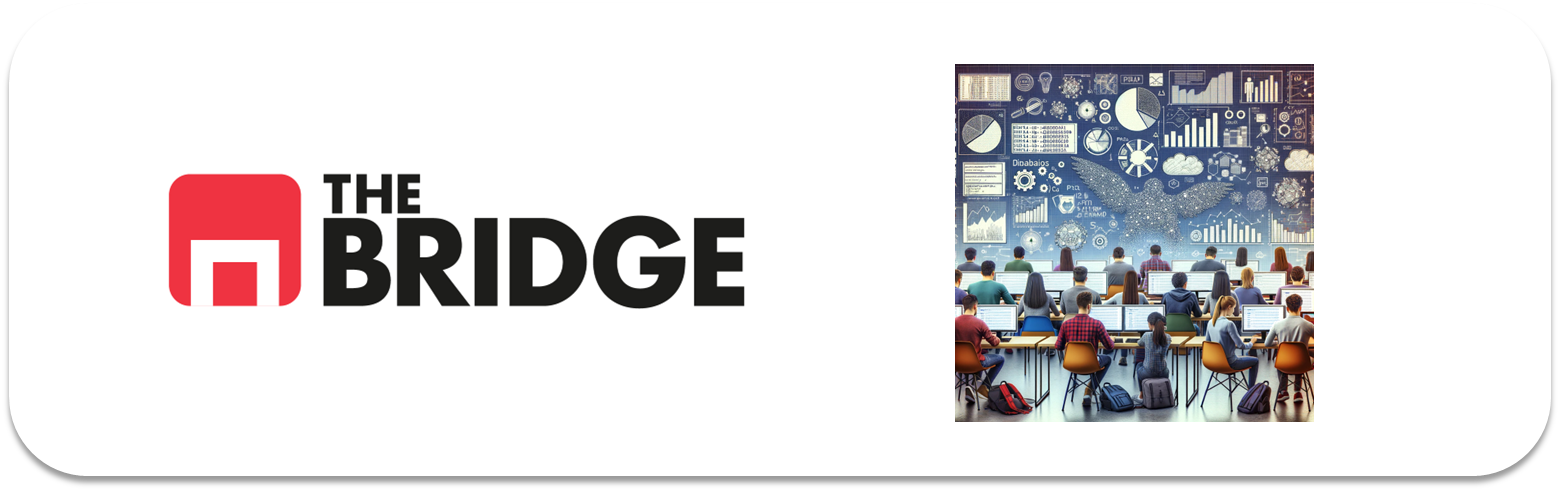

## PRACTICA OBLIGATORIA: **Clasificacion y Regresion Logistica**

* La práctica obligatoria de esta unidad consiste en ***modelar la supervivencia en el Titanic***, por fin, además de una parte adicional multiclase. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

In [243]:
import pandas as pd
import seaborn as sns
import bootcampviztools as bt

import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, balanced_accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay,classification_report

# Ajuste formato de gráficos
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Importa los paquetes y módulos que necesites a lo largo del notebook.

### Indicaciones

A continuación tienes las indicaciones para hacer el modelado. No necesariamente tienes que seguirlos al pie de la letra, porque a partir de ahora ya las práctica obligatorias dejarán de ser mayormente guiadas por ejercicios y serán más de libre desarrollo, aunque con objetivos específicos, claros y determinados. 

En concreto se pide hacer un modelo de regresión logística, evaluarlo contra un dataset de test reservado del original mostrando las métricas propias de los problemas de clasificación, la matriz de confusión y la curva ROC. Además se pide comparar las predicciones con los valores reales y al final adaptar el modelo a un problema multiclase.

Los pasos para guiar el trabajo:
1. Carga el dataset del Titanic. 
2. Deshazte de las variables que no vayas a usar. Limpia lo que creas necesarios pero no hagas imputaciones.
3. Escoge y analiza la variable target de forma gráfica y razona sobre el impacto de la distribución en los resultados esperados. Ten en cuenta que lo que queremos es poder predecir si un pasajero sobrevivirá.
4. Haz el split en train y test que creas conveniente pero asegurándote que ambos conjuntos tienen un reparto similar de pasajeros embarcados en las tres ciudades.
5. Construye las parejas X,y de train y test.
6. Ahora sí imputa los nulos con medias y modas en la X de train. Guarda esas medias que necesitarás en la parte de test.
7. Haz un mini-EDA, selecciona las features que quieres quedarte y por qué.
8. Trata las variables para que funcionen lo mejor posible en el modelo.
9. Construye un modelo de regresión logística.
10. EXTRA: Analiza si lo crees conveniente los pesos y la importancia de las features.
11. Procesa el dataset de Test para que puedas usarlo en la evaluación 
12. Evalúa tu modelo contra el dataset de test y train. Obten las matrices de confusión y las métricas que creas adecuadas. Haz un pequeño assesment de su generabilidad.
13. EXTRA: Halla la ***probabilidad de supervivencia de un hombre de entre 30 y 40 años, que embarcó en Southampton en segunda clase, viajaba solo y no pagó el billete***. PISTA: En este caso tendrás que calcular varias probabilidades y hacer la media de ellas.
14. EXTRA: Aprovecha todo el trabajo haciendo un único cambio en el target, ahora será la clase del viajero. Cambia el target quitándolo de X_train, X_test y añade a estos el target anterior. El resto no deberías cambiarlo. Entrena y evalua el modelo sólo con el classification_report.  



In [244]:
# 1. Cargar el dataset
df = pd.read_csv('./data/titanic.csv')
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [245]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    object 
 3   age          714 non-null    float64
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   embarked     889 non-null    object 
 8   class        891 non-null    object 
 9   who          891 non-null    object 
 10  adult_male   891 non-null    bool   
 11  deck         203 non-null    object 
 12  embark_town  889 non-null    object 
 13  alive        891 non-null    object 
 14  alone        891 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 92.4+ KB


* target = 'survived'
* features = 'pclass', 'age', 'sibsp', 'parch', 'fare', 'class', 'who','embark_town'
* eliminar = 'alive', 'deck', 'embarked', 'alone','sex','adult_male'

sibsp = Número de hermanos o cónyuges que viajaban con el pasajero.

Parch = Número de padres o hijos que viajaban con el pasajero.

In [246]:
target = 'survived'

In [247]:
excluidas = ['embark_town','alive','class','adult_male']

### Limpieza y primera selección

In [248]:
df_deck = df.copy()
df_deck['deck'] = df_deck.deck.fillna('UNK')

In [249]:
# excluidas = ['embark_town','alive','class','adult_male']
features_base = [col for col in df_deck.columns if col not in excluidas]
features_base.remove('deck')
features_base_deck = [col for col in df_deck.columns if col not in excluidas]

##### ***Revisar si hay duplicados y que hacer con ellos***

#### Train y split

In [250]:
# previamente rellenamos los NaN de embarked con el valor moda para no tener problemas con el stratify
df_deck.loc[df_deck['embarked'].isna(),'embarked'] = "S"

In [251]:
train_set, test_set = train_test_split(df_deck, test_size=0.2, stratify=df_deck['embarked'],random_state=42)

In [252]:
train_set.embarked.value_counts(normalize=True)

embarked
S    0.724719
C    0.188202
Q    0.087079
Name: proportion, dtype: float64

In [253]:
test_set.embarked.value_counts(normalize=True)

embarked
S    0.726257
C    0.189944
Q    0.083799
Name: proportion, dtype: float64

In [254]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 838 to 571
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     712 non-null    int64  
 1   pclass       712 non-null    int64  
 2   sex          712 non-null    object 
 3   age          561 non-null    float64
 4   sibsp        712 non-null    int64  
 5   parch        712 non-null    int64  
 6   fare         712 non-null    float64
 7   embarked     712 non-null    object 
 8   class        712 non-null    object 
 9   who          712 non-null    object 
 10  adult_male   712 non-null    bool   
 11  deck         712 non-null    object 
 12  embark_town  712 non-null    object 
 13  alive        712 non-null    object 
 14  alone        712 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 79.3+ KB


In [284]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 179 entries, 395 to 9
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     179 non-null    int64  
 1   pclass       179 non-null    int64  
 2   sex          179 non-null    float64
 3   age          179 non-null    float64
 4   sibsp        179 non-null    float64
 5   parch        179 non-null    int64  
 6   fare         179 non-null    float64
 7   embarked     179 non-null    float64
 8   class        179 non-null    object 
 9   who          179 non-null    float64
 10  adult_male   179 non-null    bool   
 11  deck         179 non-null    object 
 12  embark_town  177 non-null    object 
 13  alive        179 non-null    object 
 14  alone        179 non-null    bool   
dtypes: bool(2), float64(6), int64(3), object(4)
memory usage: 19.9+ KB


#### Imputamos valores a los NaN de 'age'

In [255]:
# obtenemos la medida que vamos a utilizar para sustituir los nan sobre el set de train y aplicamos la misma medida a test

es_hombre = train_set.who == "man"
es_mujer = train_set.who == "woman"
es_child = train_set.who == "child"

mean_man = train_set[es_hombre]['age'].mean()
mean_woman = train_set[es_mujer]['age'].mean()
mean_child = train_set[es_child]['age'].mean()

es_nulo = train_set.age.isna()
es_nulo_test = test_set.age.isna()

train_set.loc[es_hombre & es_nulo, 'age'] = mean_man
train_set.loc[es_mujer & es_nulo, 'age'] = mean_woman
train_set.loc[es_child & es_nulo, 'age'] = mean_child

test_set.loc[(test_set.who == "man") & es_nulo_test, 'age'] = mean_man
test_set.loc[(test_set.who == "woman") & es_nulo_test, 'age'] = mean_woman
test_set.loc[(test_set.who == "child") & es_nulo_test, 'age'] = mean_child


In [256]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 179 entries, 395 to 9
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     179 non-null    int64  
 1   pclass       179 non-null    int64  
 2   sex          179 non-null    object 
 3   age          179 non-null    float64
 4   sibsp        179 non-null    int64  
 5   parch        179 non-null    int64  
 6   fare         179 non-null    float64
 7   embarked     179 non-null    object 
 8   class        179 non-null    object 
 9   who          179 non-null    object 
 10  adult_male   179 non-null    bool   
 11  deck         179 non-null    object 
 12  embark_town  177 non-null    object 
 13  alive        179 non-null    object 
 14  alone        179 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 19.9+ KB


#### Mini-EDA

Frecuencias de clases: survived
0    62.640449
1    37.359551
Name: proportion, dtype: float64


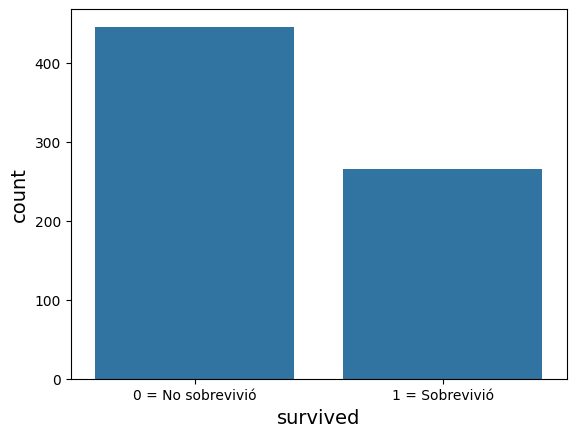

In [257]:
# 2. Variable target
print(f"Frecuencias de clases: {train_set[target].value_counts(normalize=True)*100}")

# Gráfica de targe
sns.countplot(x=train_set[target])

# Configurar los ticks personalizados en el eje x
plt.xticks(ticks=[0, 1], labels=['0 = No sobrevivió', '1 = Sobrevivió'])

# Mostrar el gráfico
plt.show()

Ligeramente desequilibrado. Habría que estudiar como equilibrarlo en caso de que los resultados no sean los adecuados para la clase que se quisiera predecir con mayor prioridad

Usaremos un pairplot para verlo mejor gracias al hue, pero en dos tandas y las categóricas ya pasadas a números (pclass, alone, adult_male) las veremos con su tabla de contingencia y el análisis visual

In [258]:
features_base

['survived',
 'pclass',
 'sex',
 'age',
 'sibsp',
 'parch',
 'fare',
 'embarked',
 'who',
 'alone']

In [259]:
# Análisis de numéricas
features_num = ['age','sibsp','parch','fare']

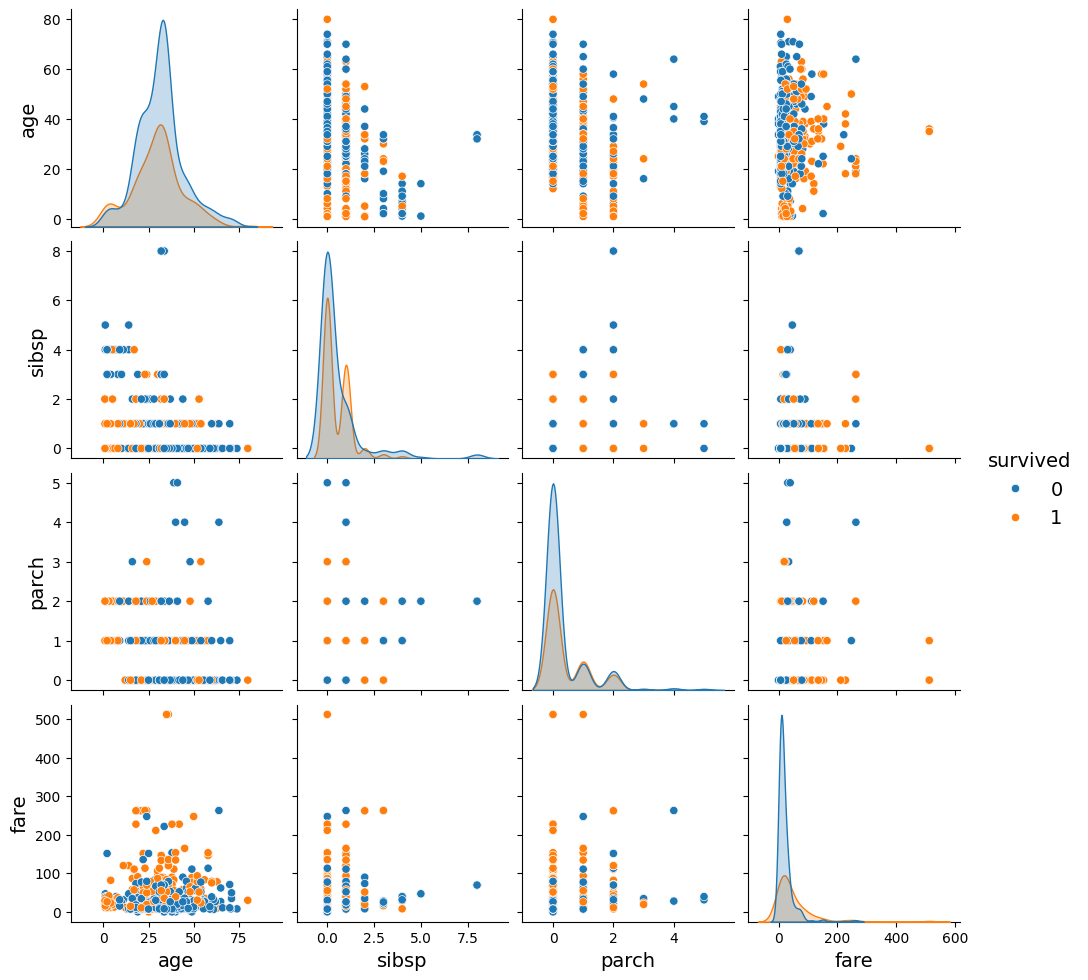

In [260]:
sns.pairplot(train_set[features_num+[target]],hue=target)

In [261]:
features_num = ['fare','age','sibsp']

In [262]:
# Análisis de variables categóricas
features_cat = ['pclass','sex','embarked','alone','who','deck']

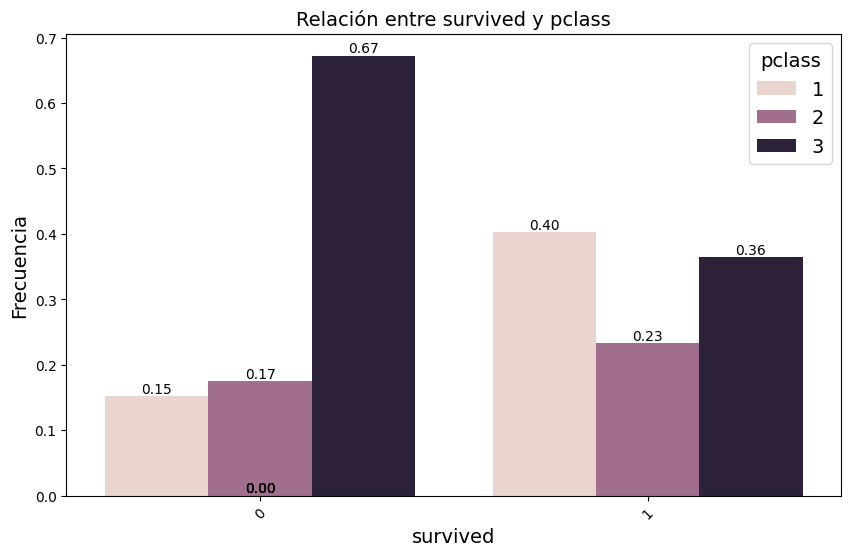

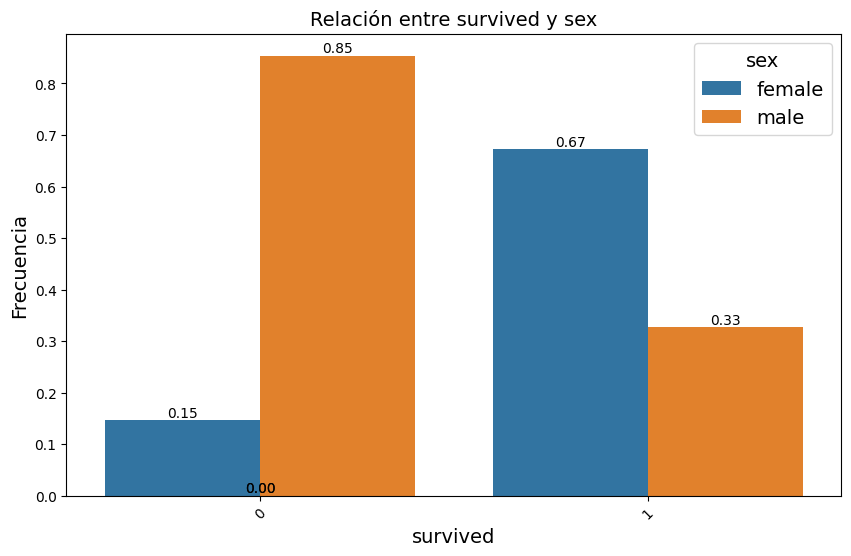

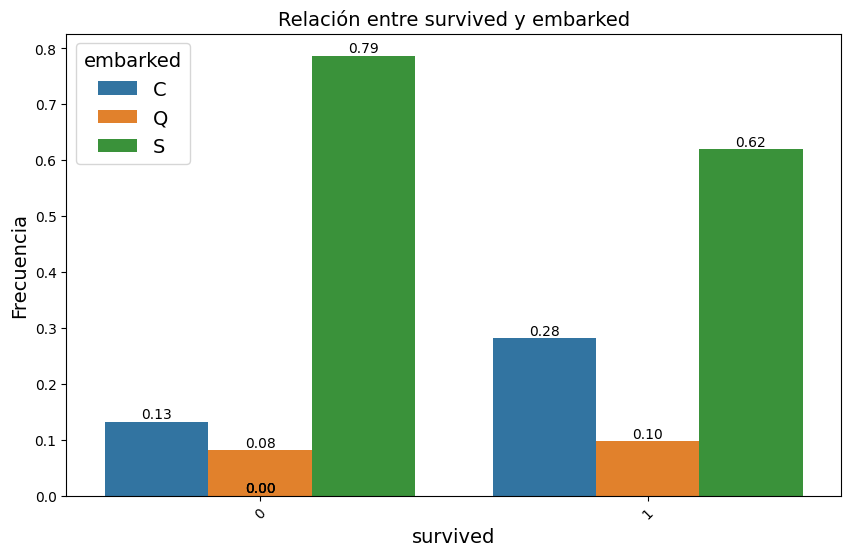

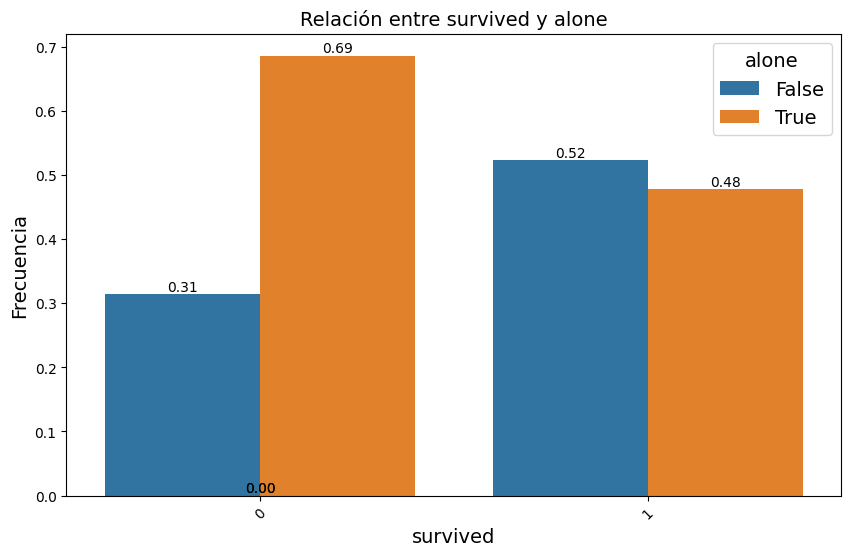

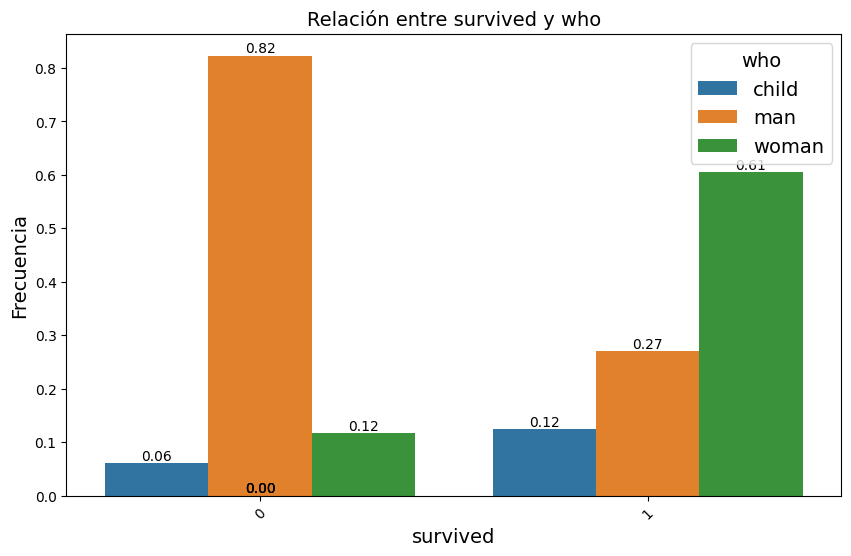

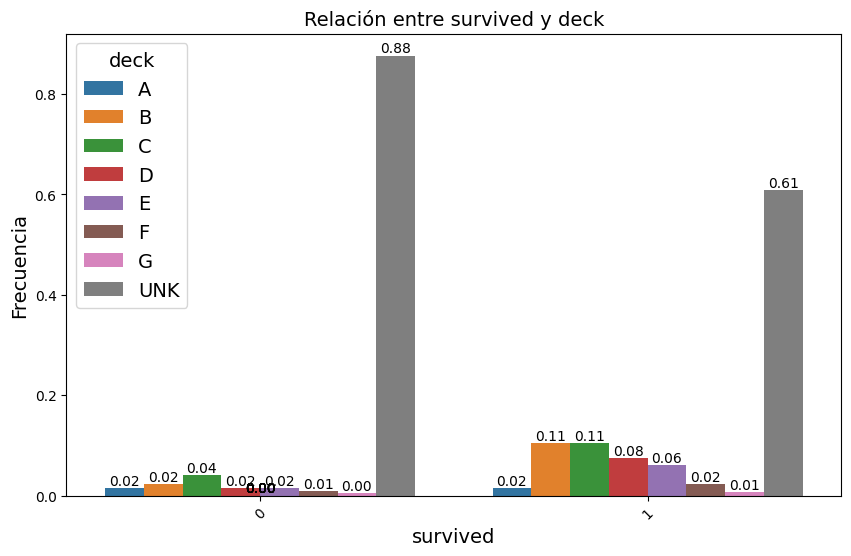

In [263]:
for feat in features_cat:
    bt.plot_categorical_relationship_fin(train_set,target,feat,show_values=True,relative_freq=True)

##### Cuando las frecuencias son significativamente diferentes hay que mantenerlas, especialmente si hay inversión

In [264]:
train_set['deck_informed'] = train_set.deck != 'UNK'

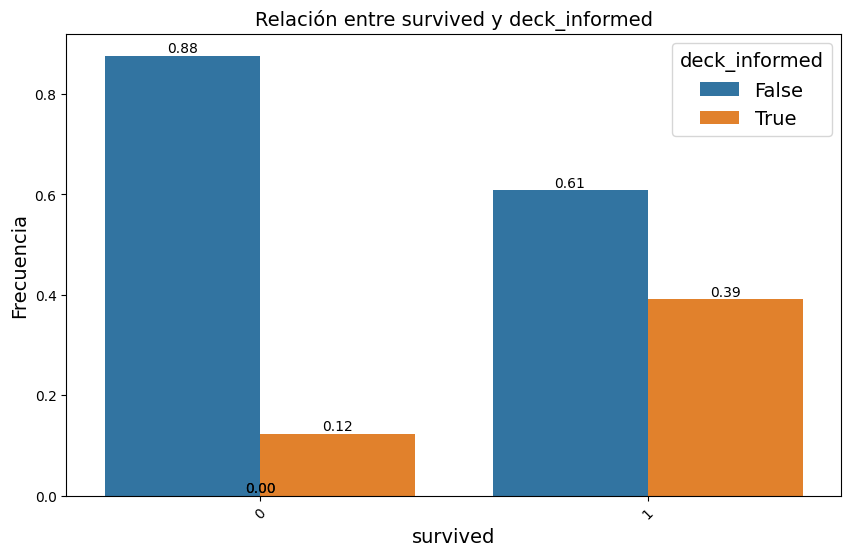

In [265]:
bt.plot_categorical_relationship_fin(train_set,target,'deck_informed',show_values=True, relative_freq=True)

Me quedo con 'pclass', 'who', 'embarked', 'alone', 'deck' (y lo probaré con deck_informed), y por si acaso 'fare' y 'age'

In [266]:
features_cat.remove('deck')
features_cat.append('deck_informed')

In [267]:
features_num

['fare', 'age', 'sibsp']

In [268]:
features_cat

['pclass', 'sex', 'embarked', 'alone', 'who', 'deck_informed']

#### Procesado categóricas

In [269]:
categorias = [['male','female'],['S','C','Q'],['child','woman','man']]
encoder = OrdinalEncoder(categories=categorias)

train_set[['sex','embarked','who']] = encoder.fit_transform(train_set[['sex','embarked','who']]) #Entrena y aplicar
test_set[['sex','embarked','who']] = encoder.transform(test_set[['sex','embarked','who']]) # Sólo aplicar lo que se ha ajustado para train

In [270]:
train_set[['sex','embarked','who']]

,sex,embarked,who
838,0.0,0.0,2.0
621,0.0,0.0,2.0
282,0.0,0.0,2.0
275,1.0,0.0,1.0
217,0.0,0.0,2.0
...,...,...,...
594,0.0,0.0,2.0
166,1.0,0.0,1.0
121,0.0,0.0,2.0
785,0.0,0.0,2.0


#### Procesado numéricas

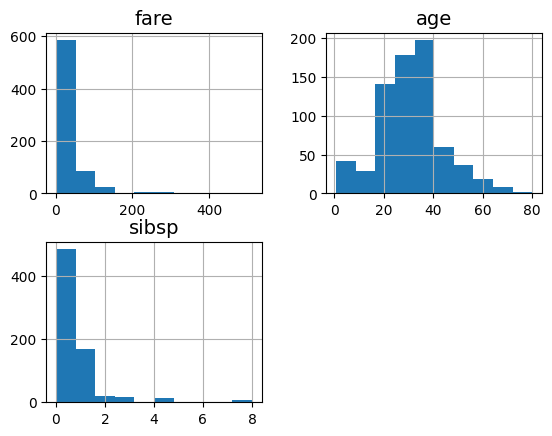

In [271]:
train_set[features_num].hist();

Cuando las variables numéricas tiene valores 0 y queremos aplicar la transformación logarítmica tiene que ser en forma (x+1) para eliminar los valores 0 y poder aplicar la transformación

<Axes: >

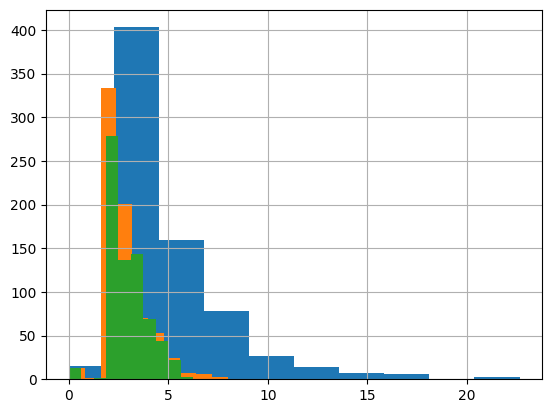

In [272]:
# otras transformaciones
np.sqrt(train_set['fare']).hist()
np.cbrt(train_set['fare']).hist() #raiz cúbica
np.log(train_set['fare']+1).hist()

<Axes: >

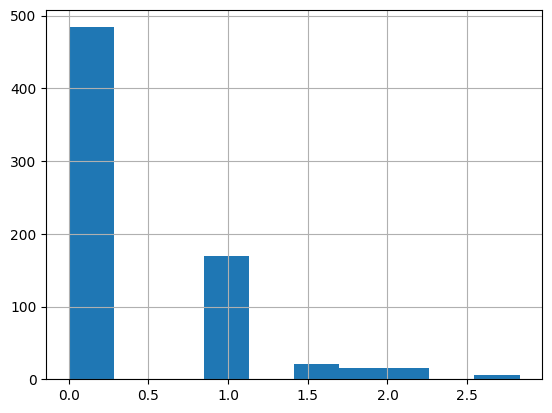

In [273]:
train_set['sibsp'].apply(np.sqrt).hist()

In [274]:
train_set['fare'] = np.sqrt(train_set['fare'])
test_set['fare'] = np.sqrt(test_set['fare'])

train_set['sibsp'] = np.sqrt(train_set['fare'])
test_set['sibsp'] = np.sqrt(test_set['fare'])

In [275]:
train_set

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,deck_informed
838,1,3,0.0,32.000000,2.741600,0,7.516369,0.0,Third,2.0,True,UNK,Southampton,yes,True,False
621,1,1,0.0,42.000000,2.692476,0,7.249428,0.0,First,2.0,True,D,Southampton,yes,False,True
282,0,3,0.0,16.000000,1.755622,0,3.082207,0.0,Third,2.0,True,UNK,Southampton,no,True,False
275,1,1,1.0,63.000000,2.971431,0,8.829400,0.0,First,1.0,False,D,Southampton,yes,False,True
217,0,2,0.0,42.000000,2.279507,0,5.196152,0.0,Second,2.0,True,UNK,Southampton,no,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,0,2,0.0,37.000000,2.258101,0,5.099020,0.0,Second,2.0,True,UNK,Southampton,no,False,False
166,1,1,1.0,32.008982,2.723270,1,7.416198,0.0,First,1.0,False,E,Southampton,yes,False,True
121,0,3,0.0,33.655689,1.684414,0,2.837252,0.0,Third,2.0,True,UNK,Southampton,no,True,False
785,0,3,0.0,25.000000,1.640909,0,2.692582,0.0,Third,2.0,True,UNK,Southampton,no,True,False


In [276]:
# Escalado
scaler = StandardScaler()

train_set[features_num] = scaler.fit_transform(train_set[features_num])
test_set[features_num] = scaler.transform(test_set[features_num])

In [277]:
train_set[features_num].describe()

,fare,age,sibsp
count,7.120000e+02,7.120000e+02,7.120000e+02
mean,1.147646e-16,-1.908586e-16,3.592632e-16
std,1.000703e+00,1.000703e+00,1.000703e+00
min,-1.619030e+00,-2.290427e+00,-3.351011e+00
25%,-6.780615e-01,-6.143837e-01,-6.850090e-01
50%,-3.458961e-01,9.100053e-02,-2.499526e-01
75%,2.318352e-01,3.950514e-01,3.880297e-01
max,5.960664e+00,3.747138e+00,4.215553e+00


In [278]:
features_set_cat_1 = ['pclass','who']
features_set_cat_2 = features_cat

In [279]:
features_num

['fare', 'age', 'sibsp']

#### Modelado

In [280]:
X_train = train_set [features_set_cat_1]
y_train = train_set[target]

X_test= test_set [features_set_cat_1]
y_test = test_set[target]

In [281]:
log_class = LogisticRegression(max_iter = 10000)

log_class.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [282]:
def metrics_titanic (model,X, y_target):
    y_pred = model.predict(X)
    ConfusionMatrixDisplay.from_predictions(y_target, y_pred)
    print(classification_report(y_target, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.92      0.85       446
           1       0.82      0.56      0.67       266

    accuracy                           0.79       712
   macro avg       0.80      0.74      0.76       712
weighted avg       0.79      0.79      0.78       712



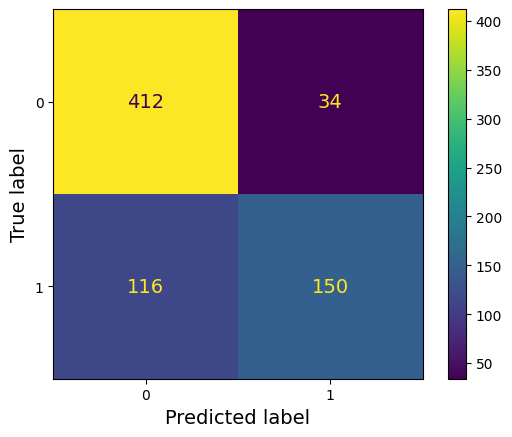

In [283]:
metrics_titanic(log_class,X_train,y_train)

              precision    recall  f1-score   support

           0       0.77      0.92      0.84       103
           1       0.86      0.63      0.73        76

    accuracy                           0.80       179
   macro avg       0.81      0.78      0.78       179
weighted avg       0.81      0.80      0.79       179



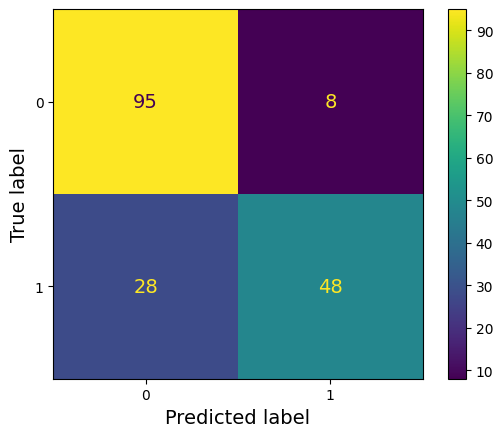

In [285]:
metrics_titanic(log_class,X_test,y_test)

AUROC: 0.88


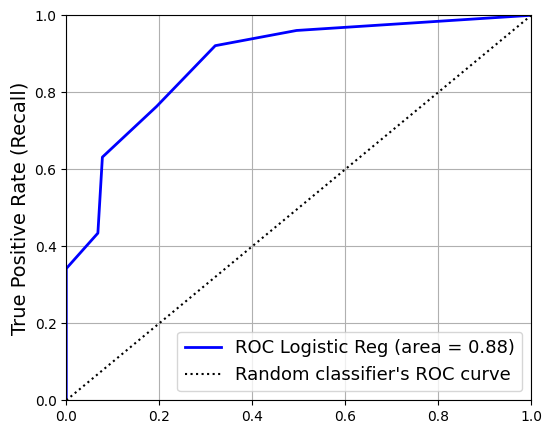

In [288]:
# Curva ROC

### Usando matplotlib
from sklearn.metrics import roc_curve, auc
scores = log_class.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, scores[:,1])
roc_auc = auc(fpr,tpr)
print("AUROC: %.2f" %(roc_auc))

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, linewidth=2, color= "blue", label=f"ROC Logistic Reg (area = {roc_auc:0.2f})")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)